In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from itertools import combinations
from sklearn.cluster import SpectralClustering

sns.set_theme()

def read_df(path):
    return pd.read_csv(path, sep="\t", compression="gzip", na_values="\\N")

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Movies dataset

In [67]:
# Load datasets
ratings = read_df("data/title.ratings.tsv.gz")
basics = read_df("data/title.basics.tsv.gz")
# Only keep movies
df = pd.merge(ratings, basics, on="tconst")
df_movies = df[df['titleType']=='movie']
# df_movies = df_movies[df_movies['numVotes'] > 10000]
df_movies.head()

KeyError: 0

In [5]:
movies_df = df_movies[['tconst', 'averageRating', 'numVotes', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres']]
movies_df

,tconst,averageRating,numVotes,primaryTitle,startYear,runtimeMinutes,genres
1612,tt0004972,6.2,24361,The Birth of a Nation,1915.0,195.0,"Drama,History,War"
2006,tt0006864,7.7,15306,Intolerance,1916.0,163.0,"Drama,History"
2646,tt0009968,7.3,10191,Broken Blossoms,1919.0,90.0,"Drama,Romance"
2750,tt0010323,8.0,62235,The Cabinet of Dr. Caligari,1920.0,76.0,"Horror,Mystery,Thriller"
3283,tt0012349,8.3,123915,The Kid,1921.0,68.0,"Comedy,Drama,Family"
...,...,...,...,...,...,...,...
1229326,tt9866072,6.1,62087,Holidate,2020.0,104,"Comedy,Romance"
1229608,tt9877170,6.5,10181,Malang,2020.0,135,"Action,Crime,Drama"
1230123,tt9893250,6.3,126688,I Care a Lot,2020.0,118,"Comedy,Crime,Drama"
1230303,tt9898858,5.1,13399,Coffee & Kareem,2020.0,88,"Action,Comedy,Crime"


In [6]:
movies_df.to_csv("data/movie_dataset.csv", index=False)

In [7]:
print(f"There are %d movies in the dataset." % len(df_movies))

There are 9847 movies in the dataset.


In [8]:
# Separate the genres into categories
dummies = pd.get_dummies(df_movies['genres'])
genres = [c for c in dummies.columns if ',' not in c]
for col in genres:
    df_movies[col] = dummies[[c for c in dummies.columns if col in c]].sum(axis=1)
df_movies.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,...,Action,Comedy,Crime,Documentary,Drama,Horror,Music,Romance,Thriller,Western
1612,tt0004972,6.2,24361,movie,The Birth of a Nation,The Birth of a Nation,0.0,1915.0,NaN,195.0,...,0,0,0,0,1,0,0,0,0,0
2006,tt0006864,7.7,15306,movie,Intolerance,Intolerance: Love's Struggle Throughout the Ages,0.0,1916.0,NaN,163.0,...,0,0,0,0,1,0,0,0,0,0
2646,tt0009968,7.3,10191,movie,Broken Blossoms,Broken Blossoms or The Yellow Man and the Girl,0.0,1919.0,NaN,90.0,...,0,0,0,0,1,0,0,1,0,0
2750,tt0010323,8.0,62235,movie,The Cabinet of Dr. Caligari,Das Cabinet des Dr. Caligari,0.0,1920.0,NaN,76.0,...,0,0,0,0,0,1,0,0,1,0
3283,tt0012349,8.3,123915,movie,The Kid,The Kid,0.0,1921.0,NaN,68.0,...,0,1,0,0,1,0,0,0,0,0


In [9]:
print(genres)

['Action', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Music', 'Romance', 'Thriller', 'Western']


Here we are interested in the average rating and number of votes of the movies and also their genres and year they came out.

In [10]:
df_movies.describe()

,averageRating,numVotes,isAdult,startYear,endYear,Action,Comedy,Crime,Documentary,Drama,Horror,Music,Romance,Thriller,Western
count,9847.000000,9.847000e+03,9847.0,9847.000000,0.0,9847.000000,9847.000000,9847.000000,9847.000000,9847.000000,9847.000000,9847.000000,9847.000000,9847.000000,9847.000000
mean,6.641800,8.622674e+04,0.0,2001.083274,NaN,0.242003,0.364172,0.204732,0.021123,0.555804,0.121052,0.042043,0.169087,0.167767,0.011476
std,1.022249,1.576563e+05,0.0,17.974602,NaN,0.428318,0.481222,0.403526,0.143802,0.496901,0.326204,0.200698,0.374848,0.373678,0.106513
min,1.100000,1.000100e+04,0.0,1915.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.100000,1.650800e+04,0.0,1994.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.700000,3.253400e+04,0.0,2006.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.400000,8.467350e+04,0.0,2014.000000,NaN,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.400000,2.569002e+06,0.0,2022.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df_movies["logNumVotes"] = np.log(df_movies["numVotes"])

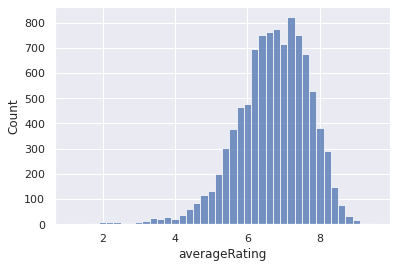

In [12]:
# How are the ratings distributed
sns.histplot(data=df_movies, x="averageRating", binwidth=0.20);

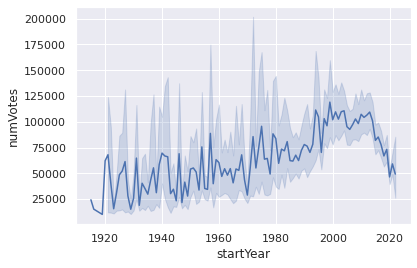

In [13]:
# Do newer movies receive more ratings ? 
sns.lineplot(data=df_movies, x="startYear", y="numVotes");

In [14]:
# What genres of movies receive more attention over time ?
# TODO: only keep n most relevant genres
df_movies["genres"].apply(lambda s: s.split(',') if isinstance(s, str) else None).explode()

1612          Drama
1612        History
1612            War
2006          Drama
2006        History
             ...   
1230303      Comedy
1230303       Crime
1230410      Action
1230410       Crime
1230410    Thriller
Name: genres, Length: 25267, dtype: object

In [15]:
# What genres of movies receive more attention over time ?
# TODO: only keep n most relevant genres
# sns.barplot(data=df_movies.explode("genres"), x="genres", y="numVotes");

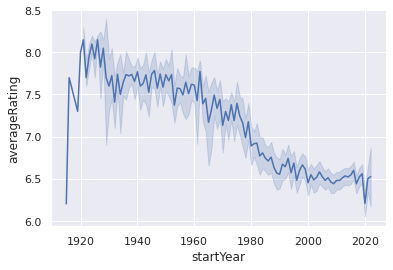

In [16]:
sns.lineplot(data=df_movies, x="startYear", y="averageRating");
# Important question: the increase of the average rating is due to real
# improvement of the movies or are we biased to give a better rating to
# what is more recent 

### Actors dataset

Here we are mostly interested in the actors, and eventually directors. The attribute "knownForTitle" will be used to link the actors together.

In [18]:
actors = pd.read_csv("data/name.basics.tsv.gz", sep="\t", compression="gzip", na_values = "\\N")
actors.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0031983,tt0050419,tt0072308,tt0053137"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0037382,tt0071877,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,music_department","tt0057345,tt0056404,tt0049189,tt0054452"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0080455,tt0078723,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0069467,tt0060827,tt0083922,tt0050986"


In [29]:
actors = actors.dropna()[
    actors["primaryProfession"].dropna().str.contains("actor")
    | actors["primaryProfession"].dropna().str.contains("actress")
]
actors.head()


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0031983,tt0050419,tt0072308,tt0053137"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0037382,tt0071877,tt0117057,tt0038355"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0080455,tt0078723,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0069467,tt0060827,tt0083922,tt0050986"
5,nm0000006,Ingrid Bergman,1915.0,1982.0,"actress,soundtrack,producer","tt0034583,tt0036855,tt0038109,tt0077711"


In [30]:
actors_df = actors[['nconst', 'primaryName', 'knownForTitles']]
actors_df

,nconst,primaryName,knownForTitles
0,nm0000001,Fred Astaire,"tt0031983,tt0050419,tt0072308,tt0053137"
1,nm0000002,Lauren Bacall,"tt0037382,tt0071877,tt0117057,tt0038355"
3,nm0000004,John Belushi,"tt0080455,tt0078723,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,"tt0069467,tt0060827,tt0083922,tt0050986"
5,nm0000006,Ingrid Bergman,"tt0034583,tt0036855,tt0038109,tt0077711"
...,...,...,...
11510809,nm9961584,Semra Atilay,"tt0263409,tt0367627,tt0368809,tt0401531"
11515523,nm9967094,Allyn M. Schmitz,"tt5591666,tt2247057"
11518604,nm9970751,Helmut Winschermann,"tt0063136,tt8696414"
11518655,nm9970811,Cristian Mosquera,"tt2066179,tt8696516"


In [92]:
actors_df.dropna(inplace=True)
actors["knownForTitles"] = actors_df["knownForTitles"].str.split(',')
df_movies_tconst = df_movies.set_index("tconst")
def numvotes(grp):
    try:
        return df_movies_tconst.loc[grp.array]["numVotes"].sum()
    except KeyError:
        return

actor_numvotes = actors.explode("knownForTitles").groupby("nconst")["knownForTitles"].apply(lambda grp: numvotes(grp)).dropna().rename("numVotes")
actors_merge = actors.merge(actor_numvotes, on="nconst")
#df_movies_tconst.loc[splitted_tconsts.explode().loc[0].array]["numVotes"].sum()

NameError: name 'actor_merge' is not defined

In [95]:
actors = actors_merge.sort_values("numVotes", ascending=False)
actors

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,splitted,numVotes
14161,nm0504226,Andrew Lesnie,1956.0,2015.0,"cinematographer,camera_department,actor","[tt0167261, tt0360717, tt0167260, tt0120737]","[tt0167261, tt0360717, tt0167260, tt0120737]",5568009.0
19894,nm0721615,Don Reynolds,1937.0,2019.0,"actor,miscellaneous","[tt0120737, tt0167260, tt0035423, tt0167261]","[tt0120737, tt0167260, tt0035423, tt0167261]",5236632.0
85,nm0000453,Ian Holm,1931.0,2020.0,"actor,soundtrack,animation_department","[tt0120737, tt0120681, tt0382932, tt0167260]","[tt0120737, tt0120681, tt0382932, tt0167260]",4405417.0
18037,nm0652906,Johnny Otis,1921.0,2012.0,"soundtrack,actor","[tt0111161, tt0088763, tt0790636, tt0117381]","[tt0111161, tt0088763, tt0790636, tt0117381]",4404535.0
219,nm0001190,David Prowse,1935.0,2020.0,"actor,miscellaneous","[tt0066921, tt0076759, tt0080684, tt0086190]","[tt0066921, tt0076759, tt0080684, tt0086190]",4379166.0
...,...,...,...,...,...,...,...,...
27769,nm12830216,Nestor Pogaçe,1915.0,1983.0,actor,[tt0354240],[tt0354240],6.0
31453,nm7694782,Damjan Berkopec,1972.0,2010.0,"actor,editor",[tt5159852],[tt5159852],5.0
29612,nm2291091,Constance Navratil,1930.0,2014.0,actress,[tt0810786],[tt0810786],5.0
28205,nm1421246,Beppie Nooy Sr.,1893.0,1976.0,actress,[tt0219548],[tt0219548],5.0


In [48]:
actors.sort_values("numVotes", ascending=False).head(3100).to_csv("data/actors_top.csv", index=False)

In [49]:
exploded_titles = actors.knownForTitles.apply(lambda s: s.split(',') if isinstance(s, str) else None).explode()

In [50]:
actors = actors.join(exploded_titles, rsuffix="_ex")

In [51]:
G_actors = nx.Graph()
G_actors.add_nodes_from(actors["primaryName"])

KeyboardInterrupt: 

In [ ]:
actors.groupby("knownForTitles_ex").primaryName.apply(lambda group: G_actors.add_edges_from(combinations(group, 2)));

Name: 
Type: Graph
Number of nodes: 4947
Number of edges: 22143
Average degree:   8.9521


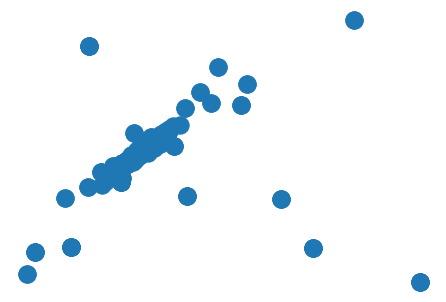

In [ ]:
print(nx.info(G_actors))
nx.draw_spectral(G_actors)
# adj_mat = nx.to_numpy_matrix(G_actors)

# spectral_clustering = SpectralClustering(10, affinity="precomputed").fit(adj_mat)